# Results

In this notebook we collect the result of the application of the genetic algorithm to hyperparameters tuning and we compare these with the more popular Bayesian optimization.

Since we used the platform Weight & Biases to log the results, we can easily retrieve the information by using the API.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from retrievement import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from tabulate import tabulate
from sklearn.linear_model import LinearRegression

import wandb
api = wandb.Api()

## Retrieving all runs' data

We can distinguish the different categories of runs by filtering out the tags, like `sinewave` or `mnist`.

### MNIST dataset

We begin by comparing the results of the two algorithms on the Sinewave dataset.

Thanks to the API, we can easily retrieve the data of all the runs with the right tags.

In [29]:
runs_GA = api.runs(path, filters=Filter.MLP_MNIST_GA)
runs_GA = list(runs_GA)

runs_BO = api.runs(path, filters=Filter.MLP_MNIST_BO)
runs_BO = list(runs_BO)

In [30]:
df_GA = runs_to_df_ga(runs_GA)
df_BO = runs_to_df_bo(runs_BO)

We can decide wether to smooth the plots or not by setting the `smooting_window` variable to $1$ or $>1$

In [31]:
smooting_window = 1

### Hyperparameters evolution

We now compare the evolution of the hyperparameters during the optimization process.
Ideally we would like to see the hyperparameters converging to a specific value. 

In [32]:
cols = ['n_layers', 'hidden_size', 'dropout']

In [33]:
# Groupby generation and apply mean
mean_GA = df_GA.groupby('generation')[cols].mean().rolling(smooting_window).mean()
mean_BO = df_BO.groupby('generation')[cols].mean().rolling(smooting_window).mean()

std_GA = df_GA.groupby('generation')[cols].std().rolling(smooting_window).mean()
std_BO = df_BO.groupby('generation')[cols].std().rolling(smooting_window).mean()

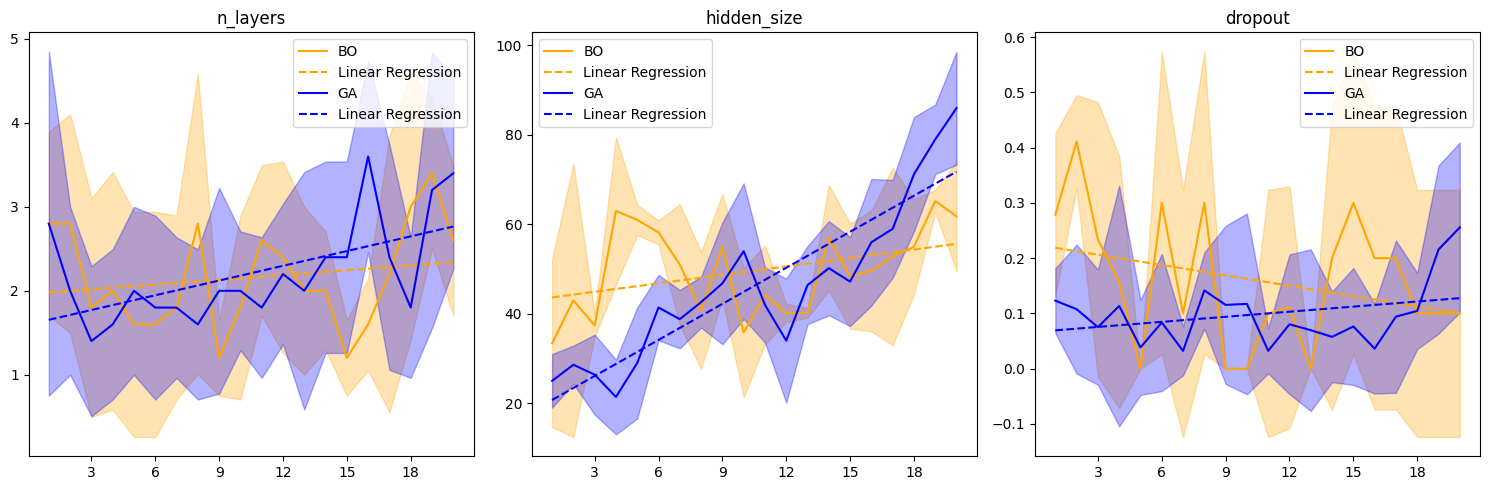

In [34]:
# Plotting
lr_regs = []
fig, ax = plt.subplots(1, len(cols), figsize=(len(cols)*5, 5))
for i, col in enumerate(cols):
    # BAYESIAN OPTIMIZATION
    # Mean and std
    ax[i].plot(mean_BO[col], label='BO', color='orange')
    ax[i].fill_between(mean_BO.index, mean_BO[col] - std_BO[col], mean_BO[col] + std_BO[col], alpha=0.3, color='orange')
    # Linear regression
    x = mean_BO.index
    y = mean_BO[col]
    reg_BO = LinearRegression().fit(x.values.reshape(-1, 1), y)
    lr_regs.append(reg_BO)
    ax[i].plot(x, reg_BO.predict(x.values.reshape(-1, 1)), label=f'Linear Regression', linestyle='--', color='orange')

    # GENETIC ALGORITHM
    # Mean and std
    ax[i].plot(mean_GA[col], label='GA', color='blue')
    ax[i].fill_between(mean_GA.index, mean_GA[col] - std_GA[col], mean_GA[col] + std_GA[col], alpha=0.3, color='blue')
    # Linear regression
    x = mean_GA.index
    y = mean_GA[col]
    reg_GA = LinearRegression().fit(x.values.reshape(-1, 1), y)
    lr_regs.append(reg_GA)
    ax[i].plot(x, reg_GA.predict(x.values.reshape(-1, 1)), label=f'Linear Regression', linestyle='--', color='blue')

    # Title
    ax[i].set_title(col)
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune=None))
    ax[i].legend()
plt.tight_layout()
plt.show()

In [35]:
table = []
for i, col in enumerate(cols):
    table.append([col, f'{lr_regs[i*2].coef_[0]:.2e}', f'{lr_regs[i*2].intercept_:.2f}', f'{lr_regs[i*2+1].coef_[0]:.2e}', f'{lr_regs[i*2+1].intercept_:.2f}'])

print(tabulate(table, headers=['Parameter', 'BO Slope', 'BO Intercept', 'GA Slope', 'GA Intercept', ], tablefmt='pretty'))

+-------------+-----------+--------------+----------+--------------+
|  Parameter  | BO Slope  | BO Intercept | GA Slope | GA Intercept |
+-------------+-----------+--------------+----------+--------------+
|  n_layers   | 1.89e-02  |     1.96     | 5.85e-02 |     1.60     |
| hidden_size | 6.30e-01  |    43.04     | 2.69e+00 |    18.03     |
|   dropout   | -6.24e-03 |     0.23     | 3.07e-03 |     0.07     |
+-------------+-----------+--------------+----------+--------------+


### Metrics evolution

We now compare the evolution of the metrics during the optimization process. Ideally we would like to see the metrics converging to their best value, 0 for mse and mae.

In [36]:
cols = ['val_mse', 'val_mae']

In [37]:
# Groupby generation and apply mean
mean_GA = df_GA.groupby('generation')[cols].mean().rolling(smooting_window).mean()
mean_BO = df_BO.groupby('generation')[cols].mean().rolling(smooting_window).mean()

std_GA = df_GA.groupby('generation')[cols].std().rolling(smooting_window).mean()
std_BO = df_BO.groupby('generation')[cols].std().rolling(smooting_window).mean()

best_so_far_GA = df_GA.groupby('generation')[cols].min().rolling(smooting_window).mean()
best_so_far_BO = df_BO.groupby('generation')[cols].min().rolling(smooting_window).mean()

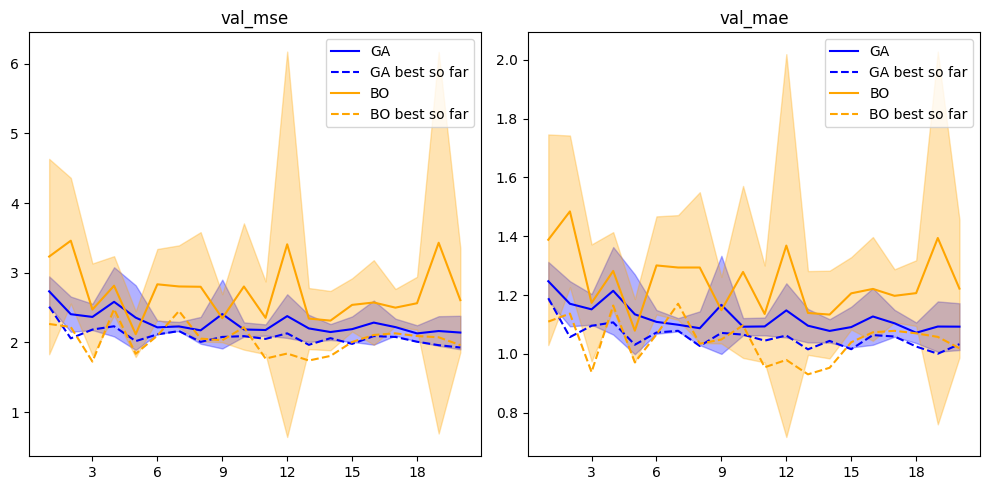

In [38]:
# Plotting
fig, ax = plt.subplots(1, len(cols), figsize=(len(cols)*5, 5))
for i, col in enumerate(cols):
    # GENETIC ALGORITHM
    # Mean and std
    ax[i].plot(mean_GA[col], label='GA', color='blue')
    ax[i].fill_between(mean_GA.index, mean_GA[col] - std_GA[col], mean_GA[col] + std_GA[col], alpha=0.3, color='blue')
    # Best so far
    ax[i].plot(best_so_far_GA[col], label='GA best so far', linestyle='--', color='blue')

    # BAYESIAN OPTIMIZATION
    # Mean and std
    ax[i].plot(mean_BO[col], label='BO', color='orange')
    ax[i].fill_between(mean_BO.index, mean_BO[col] - std_BO[col], mean_BO[col] + std_BO[col], alpha=0.3, color='orange')
    # Best so far
    ax[i].plot(best_so_far_BO[col], label='BO best so far', linestyle='--', color='orange')

    # Title
    ax[i].set_title(col)
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune=None))
    ax[i].legend()
plt.tight_layout()
plt.show()

This time BO overperformed GA. However we can see that the GA has a smoother trend with less variance.

We now compare the best 5 models found by the two algorithms.

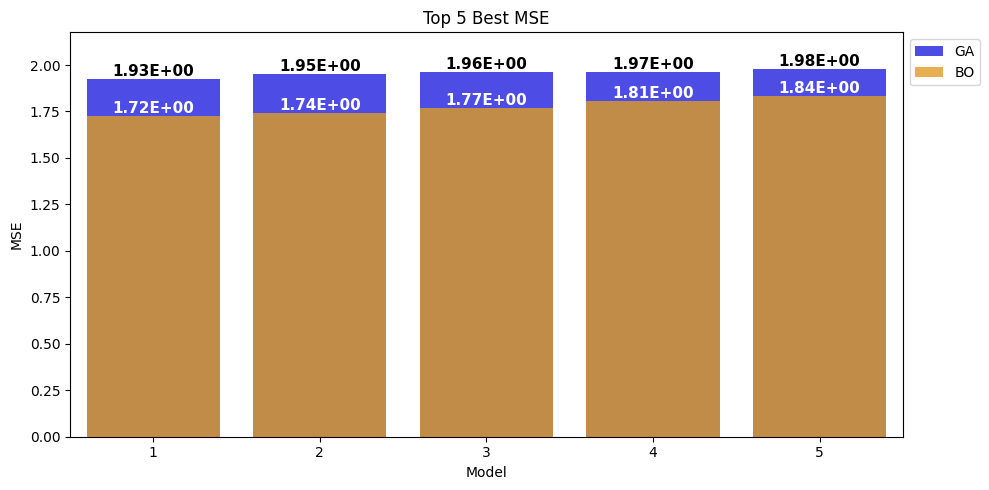

In [39]:
best_5_GA = df_GA.sort_values('val_mse').head(5)['val_mse']
best_5_BO = df_BO.sort_values('val_mse').head(5)['val_mse']

# Reset index
best_5_GA = best_5_GA.reset_index(drop=True)
best_5_BO = best_5_BO.reset_index(drop=True)

# Bar Plot
fig, ax = plt.subplots(figsize=(10, 5))
x_axis = np.arange(len(best_5_BO)) + 1
sns.barplot(x=x_axis, y=best_5_GA, ax=ax, color='blue', label='GA', alpha=0.8)
sns.barplot(x=x_axis, y=best_5_BO, ax=ax, color='orange', label='BO', alpha=0.8)

# Adding data labels
for i, (bo, ga) in enumerate(zip(best_5_BO, best_5_GA)):
    ax.text(i, bo + 0.00001, f'{bo:.2E}', ha='center', va='bottom', color='white', fontsize=11, fontweight='bold')
    ax.text(i, ga + 0.00001, f'{ga:.2E}', ha='center', va='bottom', color='black', fontsize=11, fontweight='bold')

# Customizing the plot
ax.set_ylim(0, max(max(best_5_GA), max(best_5_BO)) * 1.1)  # Add 10% space above the tallest bar
ax.set_title('Top 5 Best MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('Model')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

As we can see from the bar plot, the best five models found by the genetic algorithm are better than the ones found by the Bayesian optimization.